In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline ensures that the plot is displayed directly below the code cell in the notebook interface, allowing you to view the plot without needing to open a separate window.

In [11]:
class Value:
        
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='constant')
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward

        return out
    
    def __radd__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label='constant')
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int or float operation"
        t = self.data ** other
        out = Value(t, (self, ), f"**{other}")

        def backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = backward

        return out
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        t = math.tanh(self.data)
        out = Value(t, (self, ), 'tanh')

        def backward():
            self.grad += (1.0 - t ** 2) * out.grad
        out._backward = backward

        return out
    
    def exp(self):
        t = math.exp(self.data)
        out = Value(t, (self, ), 'exp')

        def backward():
            self.grad += t * out.grad
        out._backward = backward

        return out
    
    def backprop(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
        

In [12]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{ %s| data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #edge was added as (child, v)
        #connect n1 to operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

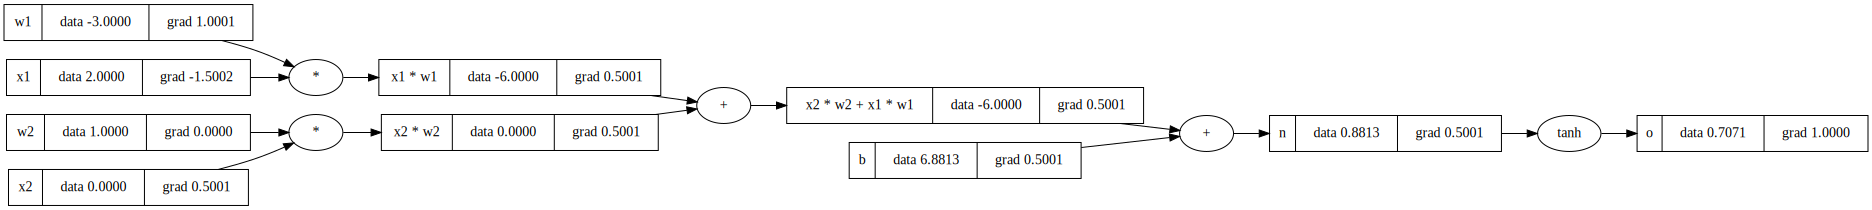

In [13]:
#designing an actual possible neural network

#input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#sum
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x2 * w2 + x1 * w1'
n = x1w1x2w2 + Value(6.8813, label='b'); n.label = 'n'
o = n.tanh(); o.label='o' 

o.backprop()
draw_dot(o)


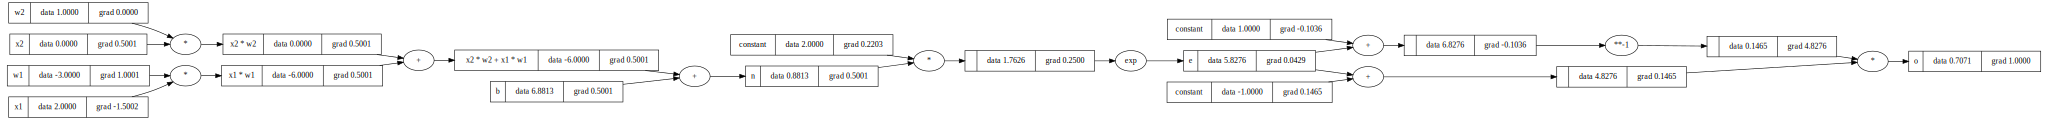

In [14]:
#designing an actual possible neural network

#input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#sum
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x2 * w2 + x1 * w1'
n = x1w1x2w2 + Value(6.8813, label='b'); n.label = 'n'
e = (n * 2).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backprop()
draw_dot(o)

In [15]:
# designing an equation

# k = exp(a + b) * 2 * (f + g) + (a + j)*2

a = Value(2, label='a')
b = Value(0.2, label='b')
c = a + b; c.label = 'c'
d = c.exp(); d.label = 'd'
e = 2 * d; e.label = 'e'
f = Value(0.3, label='f')
g = Value(0.1, label='g')
h = f + g; h.label = 'h'
i = h * e; i.label = 'i'
j = Value(1.3, label='j')
m = j + a; m.label = 'm'
k = 2 + m; k.label = 'k'
l = k + i; l.label = 'l'

draw_dot(l)
l.backprop()
draw_dot(l)

def check():
    delta = 0.0001

    a = Value(2, label='a')
    b = Value(0.2, label='b')
    c = a + b; c.label = 'c'
    d = c.exp(); d.label = 'd'
    e = 2 * d; e.label = 'e'
    f = Value(0.3, label='f')
    g = Value(0.1, label='g')
    h = f + g; h.label = 'h'
    i = h * e; i.label = 'i'
    j = Value(1.3, label='j')
    m = j + a; m.label = 'm'
    k = 2 + m; k.label = 'k'
    l = k + i; l.label = 'l' 
    L1 = l.data

    a = Value(2 + delta, label='a')
    b = Value(0.2, label='b')
    c = a + b; c.label = 'c'
    d = c.exp(); d.label = 'd'
    e = 2 * d; e.label = 'e'
    f = Value(0.3, label='f')
    g = Value(0.1, label='g')
    h = f + g; h.label = 'h'
    i = h * e; i.label = 'i'
    j = Value(1.3, label='j')
    m = j + a; m.label = 'm'
    k = 2 + m; k.label = 'k'
    l = k + i; l.label = 'l' 
    L2 = l.data

    print((L2 - L1)/delta)

check()

9.220371812155292


In [16]:
a = Value(2.0 , label='a')
b = a**2
c = a/b


c.backprop()
draw_dot(c)

def check():
    delta = 0.0001

    a = Value(2.0 , label='a')
    b = a**2
    c = a / b
    L1 = c.data

    a = Value(2.0 + delta , label='a')
    b = a**2
    c = a / b
    L2 = c.data

    print((L2 - L1)/delta)

check()

-0.2499875006256591


In [17]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('---')

0.7071050214706146
---
x2 0.5000024886110417
x1 -1.500007465833125
w1 1.0000049772220834
w2 0.0
---


In [45]:
#now let's build a neural network
import random

class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #zip takes two iterator and return the list of their iterator
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [43]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, -1.0] #desired targets

ypred = [n(x) for x in xs] 
# print(ypred)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss.backprop()

0.4188825196444267

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
n.parameters()

[Value(data=-0.6275325452419733),
 Value(data=0.24435524536678122),
 Value(data=-0.3079737548727457),
 Value(data=0.3434532586342416),
 Value(data=-0.7072600658447212),
 Value(data=-0.15618494392351168),
 Value(data=-0.16222928976424655),
 Value(data=0.21487114850440459),
 Value(data=-0.44842943140066005),
 Value(data=-0.3107276355133084),
 Value(data=0.7279234606703338),
 Value(data=-0.6567835015460206),
 Value(data=0.8061756241284164),
 Value(data=-0.141604026256559),
 Value(data=-0.8485783050213784),
 Value(data=0.2184027174905121),
 Value(data=-0.09408511272301245),
 Value(data=-0.21630127067573124),
 Value(data=0.7885180571461339),
 Value(data=-0.11390587660001716),
 Value(data=-0.9442920673824393),
 Value(data=0.7516755207684307),
 Value(data=0.3513581339076943),
 Value(data=0.9411386427808037),
 Value(data=0.7389076974046196),
 Value(data=-0.1997815791430526),
 Value(data=0.7684743884472707),
 Value(data=0.5346488925909127),
 Value(data=0.2524842895335915),
 Value(data=-0.459583

In [48]:
len(n.parameters())

41

In [50]:
for p in n.parameters():
    p.data += 0.01 * p.grad

In [ ]:
# we decreased the loss... moretodo!!!